# **Notes**

- 10000 entries -> no missing values
- 14 columns: 9 int, 2 float, 3 object
- ``'RowNumber'`` ``'CustomerId'`` ``'Surname'`` and ``'Gender'`` are useless columns
- 80/20 target repartition -> not imbalanced
- Need to scale data

## Model selected : **Neural Network**

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

from sklearn.preprocessing import LabelEncoder
 
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix,classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
data = pd.read_csv('customer-churn/Churn_Data.csv')
data.info()
data.isnull().sum()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
# We are going to drop the columns that are not useful for our analysis
df_churn = data.copy()
df_churn.drop(['Surname'],axis=1,inplace=True)
df_churn.drop(['Gender'],axis=1,inplace=True)
df_churn.drop(['RowNumber'],axis=1,inplace=True)
df_churn.drop(['CustomerId'],axis=1,inplace=True)
df_churn.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,41,1,83807.86,1,0,1,112542.58,0
2,502,France,42,8,159660.80,3,1,0,113931.57,1
3,699,France,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,43,2,125510.82,1,1,1,79084.10,0


In [4]:
palette={"Germany": "#F0E100", "France": "#01295F", "Spain": "#F17105"}
palette_df=pd.DataFrame(palette.items(), columns=['Geography', 'Color'])
palette_df
customersa=pd.DataFrame(df_churn['Geography'].value_counts(normalize=False))
customersa=customersa.reset_index().rename(columns = {'index':'Geography','Geography':'Count'})

customers=pd.merge(customersa, palette_df, on=['Geography'],how='outer')

fig = go.Figure(data=[go.Pie(labels=customers['Geography'], values=customers['Count'],textinfo='label',
                     name='Customers Geographical Locations', 
                     marker_colors=customers['Color'],hole=0.5)])
fig.show()

# Churners and Non-Churners based on their country
churners=df_churn[df_churn['Exited']==1]
nonchurners=df_churn[df_churn['Exited']==0]

churners_counta=pd.DataFrame(churners['Geography'].value_counts(normalize=False))
churners_counta=churners_counta.reset_index().rename(columns = {'index':'Geography','Geography':'Count'})
churners_count=pd.merge(churners_counta, palette_df, on=['Geography'],how='outer')

nonchurners_counta=pd.DataFrame(nonchurners['Geography'].value_counts(normalize=False))
nonchurners_counta=nonchurners_counta.reset_index().rename(columns = {'index':'Geography','Geography':'Count'})
nonchurners_count=pd.merge(nonchurners_counta, palette_df, on=['Geography'],how='outer')

fig = make_subplots(rows=1, cols=2, 
                    specs=[[{"type": "pie"},{"type": "pie"}]],
                    subplot_titles=("Churners by Location","Non-churners by Location"))

fig.add_trace(go.Pie(labels=churners_count['Geography'], values=churners_count['Count'],textinfo='label',
                     name='Churners Geographical Locations', 
                     marker_colors=churners_count['Color'],hole=0.5),1,1)

fig.add_trace(go.Pie(labels=nonchurners_count['Geography'], values=nonchurners_count['Count'],textinfo='label',
                     name='Non-Churners Geographical Locations',  
                     marker_colors=nonchurners_count['Color'],hole=0.5),1,2)

,Exited,Count
0,0,7963
1,1,2037


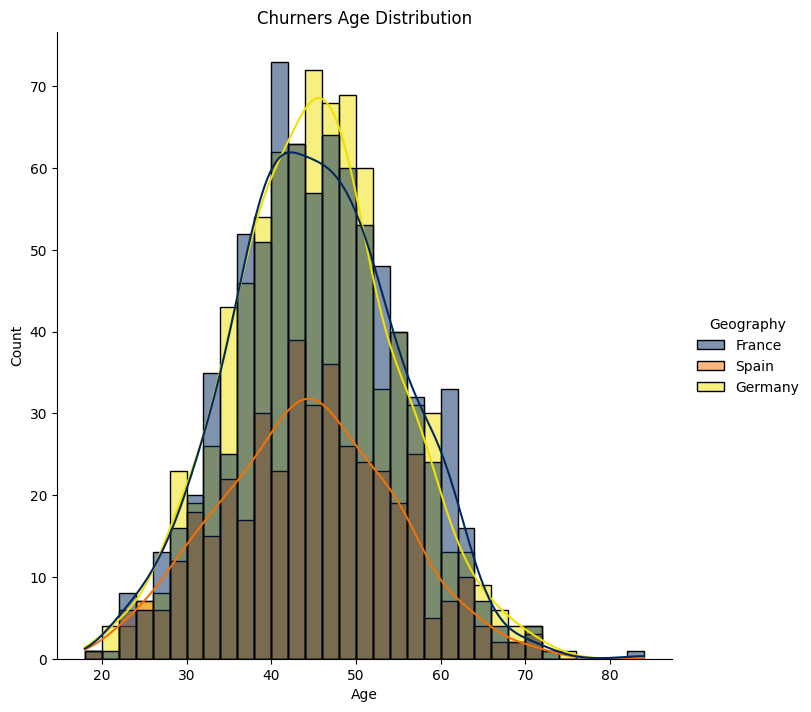

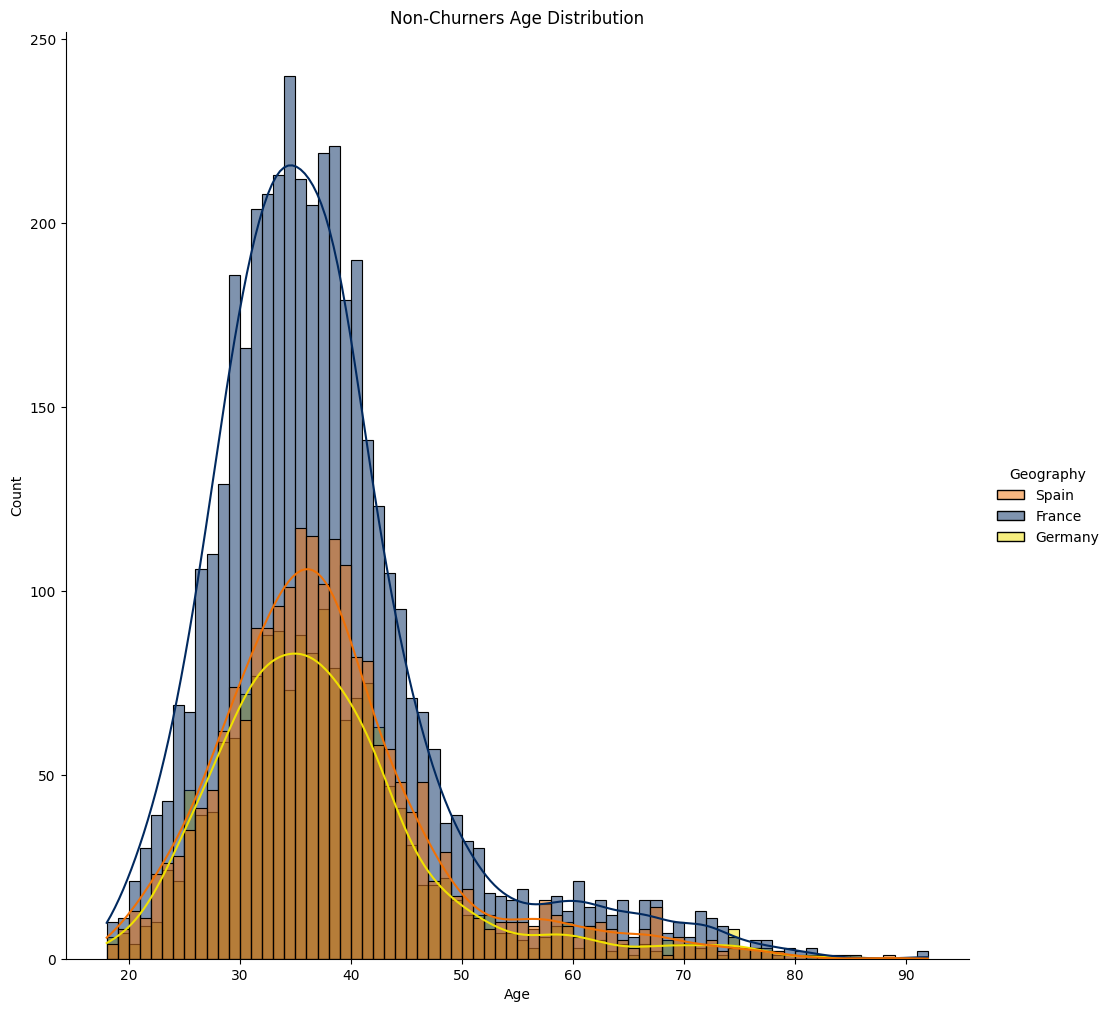

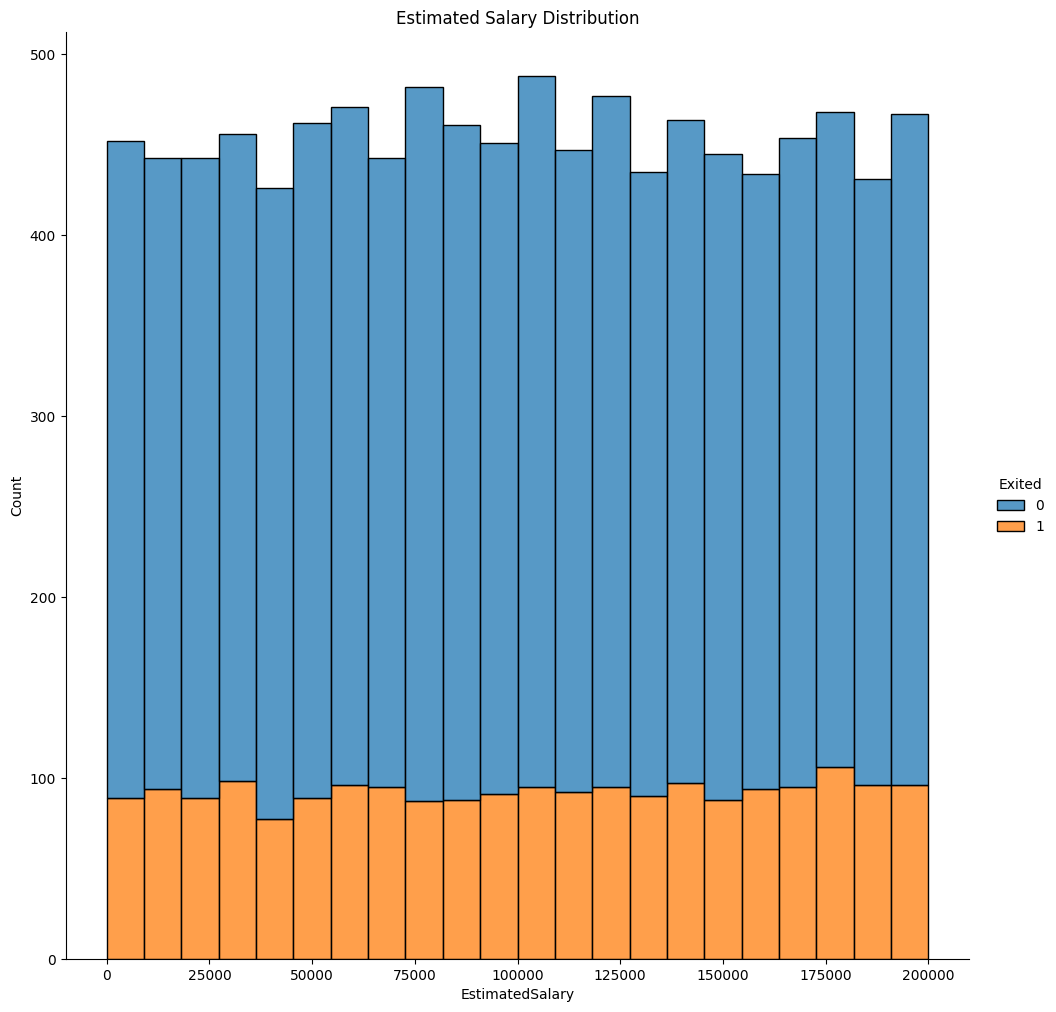

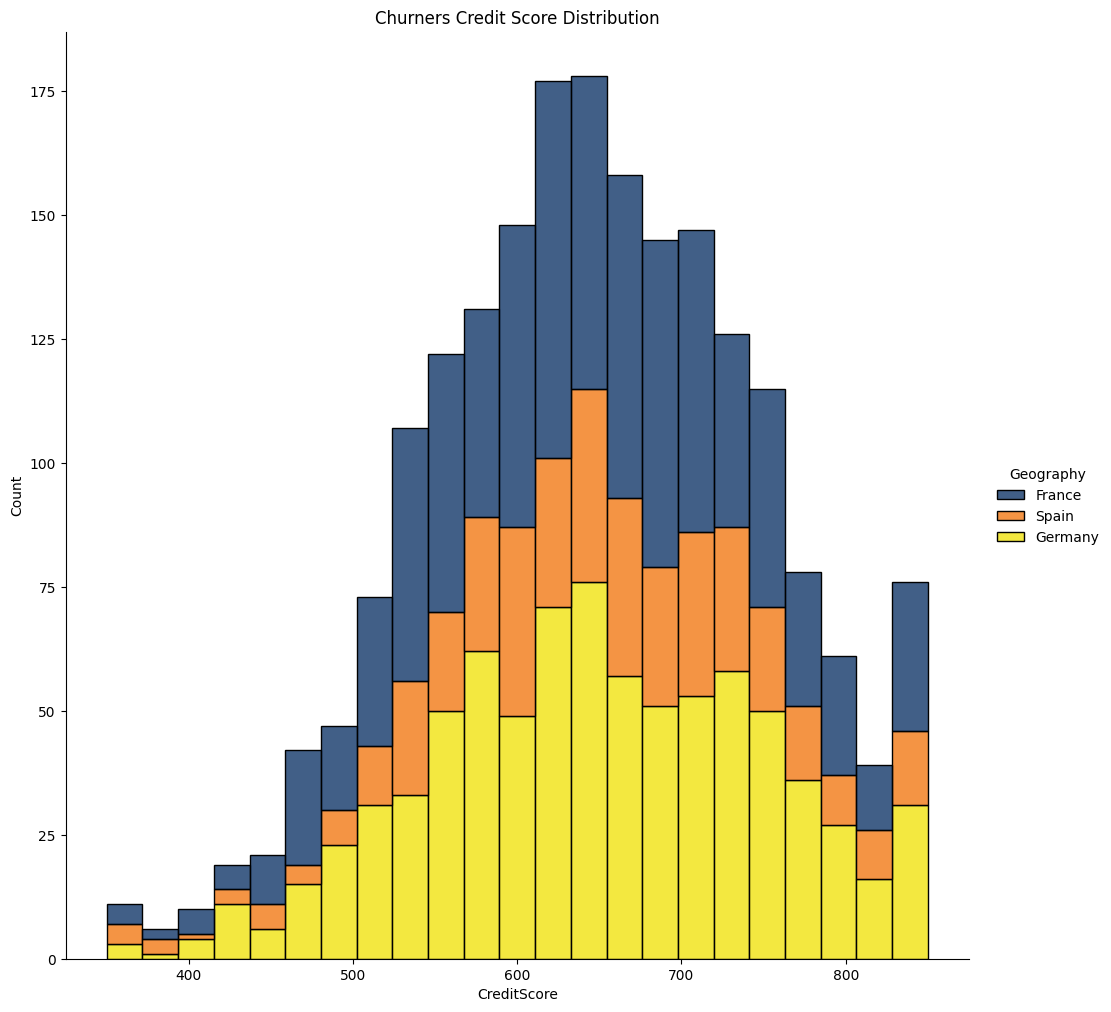

In [5]:
sns.displot(data=churners, x="Age", hue='Geography', kde=True, height=7, palette=palette).set(title='Churners Age Distribution')
sns.displot(data=nonchurners, x="Age", hue='Geography', kde=True, height=10, palette=palette).set(title='Non-Churners Age Distribution')
sns.displot(df_churn, x="EstimatedSalary", hue="Exited", multiple="stack", height=10).set(title='Estimated Salary Distribution')
sns.displot(churners, x="CreditScore", hue="Geography", multiple="stack", height=10, palette=palette).set(title='Churners Credit Score Distribution')
balance_df=pd.DataFrame(df_churn['Exited'].value_counts(normalize=False))
balance_df=balance_df.reset_index().rename(columns = {'index':'Exited','Exited':'Count'})
balance_df

In [6]:
df_churn.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,41,1,83807.86,1,0,1,112542.58,0
2,502,France,42,8,159660.80,3,1,0,113931.57,1
3,699,France,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,43,2,125510.82,1,1,1,79084.10,0


# Preprocessing

In [7]:
df_churn = pd.get_dummies(df_churn, columns=['Geography'])

In [35]:
X = df_churn.drop(['Exited'], axis=1)
y = df_churn['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5134)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(y_train.shape)
print(y_test.shape)

(8000,)
(2000,)


# Model

## Random Forest Classifier
**TODO : CROSS VAL**

In [ ]:
# Random Forest Classifier
rf = RandomForestClassifier(criterion='gini', n_estimators=100, random_state=5134)
params = {
    'n_estimators': [100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}
clf = GridSearchCV(rf, params, cv=5)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


C:\Users\Amaury Gauthier\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning:


240 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
79 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Amaury Gauthier\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Amaury Gauthier\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qb

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=5134),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             verbose=2)

In [27]:
rf_best_params = clf.best_params_
rf = RandomForestClassifier(**rf_best_params, random_state=5134)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=5134)

Accuracy: 0.8705
F1 Score: 0.5959438377535102
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92      1603
           1       0.78      0.48      0.60       397

    accuracy                           0.87      2000
   macro avg       0.83      0.72      0.76      2000
weighted avg       0.86      0.87      0.86      2000



Text(70.72222222222221, 0.5, 'Actual')

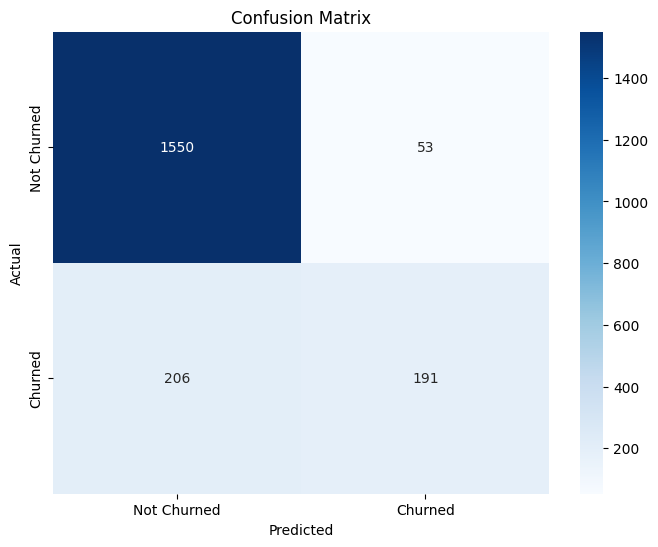

In [28]:
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Not Churned', 'Churned'], columns=['Not Churned', 'Churned'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

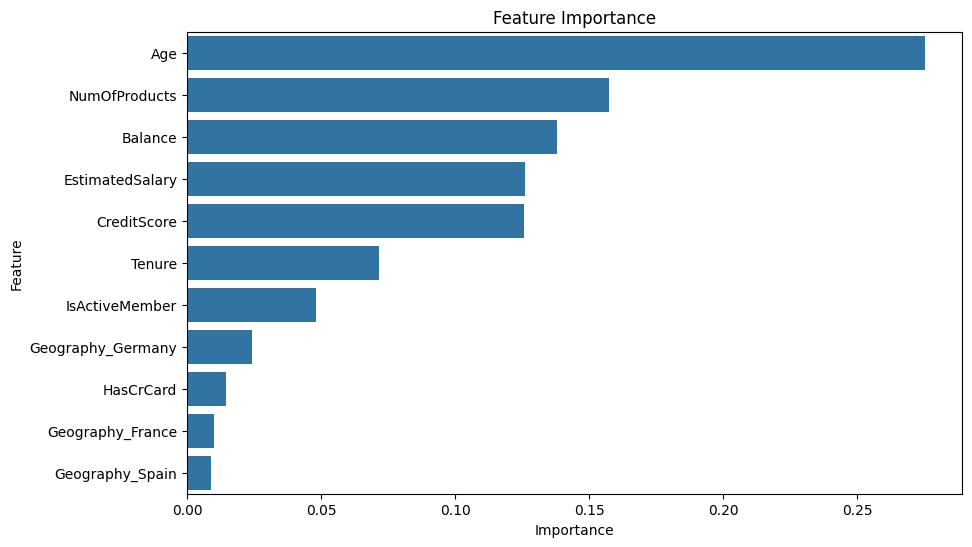

In [ ]:
# Feature Importance
importances = rf.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [ ]:
# Select features with importance greater than 10% of importance
threshold = 0.01
selected_features = feature_importance_df[feature_importance_df['Importance'] > threshold]['Feature'].tolist()

# Filter the dataset to include only selected features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5134)

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

scaler = StandardScaler()
X_train_selected = scaler.fit_transform(X_train)
X_test_selected = scaler.transform(X_test)


In [34]:
rf.fit(X_train_selected, y_train)
y_pred = rf.predict(X_test_selected)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8705
F1 Score: 0.5959438377535102
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92      1603
           1       0.78      0.48      0.60       397

    accuracy                           0.87      2000
   macro avg       0.83      0.72      0.76      2000
weighted avg       0.86      0.87      0.86      2000



No remarkable improvements on Acc, F1 Score or Recall with Cross Validation and Features Selection.

## XGBoost Classifier
**TODO : CROSS VAL**

In [ ]:
# XGBoost Classifier
xgb_model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=3, random_state=5134)
params = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'min_child_weight': [1, 2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
clf = GridSearchCV(xgb_model, params, cv=5)
rf_best_params
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

Accuracy: 0.8635
F1 Score: 0.5252173913043479
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.98      0.92      1603
           1       0.85      0.38      0.53       397

    accuracy                           0.86      2000
   macro avg       0.86      0.68      0.72      2000
weighted avg       0.86      0.86      0.84      2000



Text(70.72222222222221, 0.5, 'Actual')

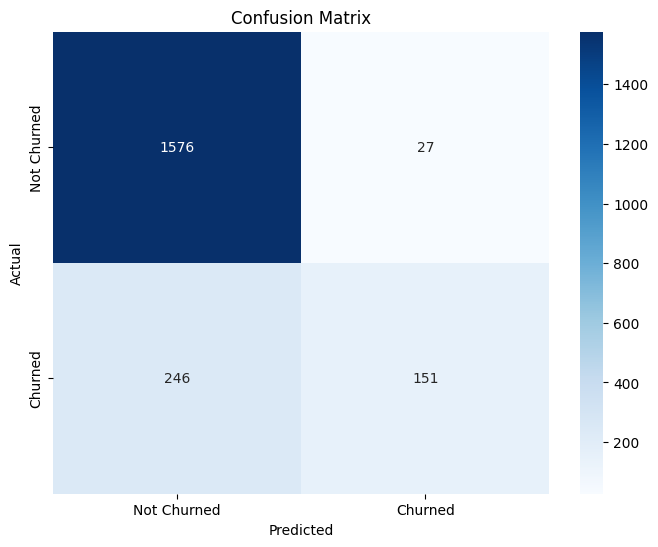

In [36]:
y_pred_xgb = xgb_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
cm = confusion_matrix(y_test, y_pred_xgb)
cm_df = pd.DataFrame(cm, index=['Not Churned', 'Churned'], columns=['Not Churned', 'Churned'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

## Neural Network

In [ ]:
X = df_churn.drop(['Exited'], axis=1)
y = df_churn['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=5134)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=5134)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

In [12]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [13]:
# Early Stopping
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [14]:
# Neural Network Classifier
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [15]:
# Initialize the model
input_size = df_churn.shape[1] - 1  # Number of features
hidden_size = 50  # Number of hidden units
num_classes = 2
model = SimpleNN(input_size, hidden_size, num_classes)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.8199
Epoch [2/10], Loss: 0.1655
Epoch [3/10], Loss: 0.5378
Epoch [4/10], Loss: 0.1936
Epoch [5/10], Loss: 0.3103
Epoch [6/10], Loss: 0.4676
Epoch [7/10], Loss: 0.1256
Epoch [8/10], Loss: 0.2173
Epoch [9/10], Loss: 0.5631
Epoch [10/10], Loss: 0.4015


In [17]:
# Initialize the model, loss function, and optimizer
model = SimpleNN(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize early stopping
early_stopping = EarlyStopping(patience=5, min_delta=0.001)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, targets in val_loader:
            outputs = model(data)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}')

    # Early stopping check
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

Epoch [1/100], Training Loss: 0.5595, Validation Loss: 0.4335
Epoch [2/100], Training Loss: 0.5286, Validation Loss: 0.4034
Epoch [3/100], Training Loss: 0.5288, Validation Loss: 0.3829
Epoch [4/100], Training Loss: 0.5305, Validation Loss: 0.3699
Epoch [5/100], Training Loss: 0.5363, Validation Loss: 0.3543
Epoch [6/100], Training Loss: 0.5347, Validation Loss: 0.3470
Epoch [7/100], Training Loss: 0.5572, Validation Loss: 0.3453
Epoch [8/100], Training Loss: 0.5647, Validation Loss: 0.3452
Epoch [9/100], Training Loss: 0.5422, Validation Loss: 0.3401
Epoch [10/100], Training Loss: 0.5462, Validation Loss: 0.3379
Epoch [11/100], Training Loss: 0.5330, Validation Loss: 0.3382
Epoch [12/100], Training Loss: 0.5354, Validation Loss: 0.3399
Epoch [13/100], Training Loss: 0.5423, Validation Loss: 0.3373
Epoch [14/100], Training Loss: 0.5563, Validation Loss: 0.3403
Epoch [15/100], Training Loss: 0.5341, Validation Loss: 0.3377
Early stopping triggered


Test Accuracy: 0.8707
F1 Score: 0.8594


Text(70.72222222222221, 0.5, 'Actual')

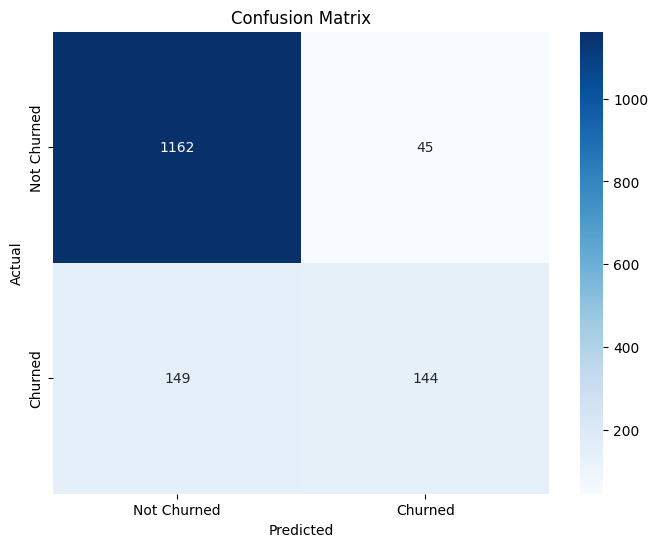

In [18]:
# Evaluate the model
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = accuracy_score(y_test_tensor, predicted)
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1_score(y_test_tensor, predicted, average="weighted"):.4f}')
cm = confusion_matrix(y_test_tensor, predicted)
cm_df = pd.DataFrame(cm, index=['Not Churned', 'Churned'], columns=['Not Churned', 'Churned'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')